In [1]:
from PIL import Image
import os
import sys
import time
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2

c:\users\user\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\user\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\user\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\users\user\appdata\

# 圖片前處理

In [2]:
def get_filenames(dataset_dir):
    captcha_names = []
    for filename in sorted(os.listdir(dataset_dir)):
        path = os.path.join(dataset_dir, filename)
        captcha_names.append(path)
    return captcha_names

dataPath = r'..\data'

image_filenames = get_filenames(dataPath)    # 取得所有圖片的檔案路徑
random.shuffle(image_filenames)              # 打亂順序

n_train = 5600    # 訓練集數量
train_filenames = image_filenames[:n_train]    # 訓練集片的檔案路徑
test_filenames = image_filenames[n_train:]     # 測試集片的檔案路徑

# SHOW
train_filenames[:5]

['..\\data\\PDWB.jpg',
 '..\\data\\IDTZ.jpg',
 '..\\data\\YKTY.jpg',
 '..\\data\\LHDX.jpg',
 '..\\data\\VUIY.jpg']

In [3]:
def convert_dataset(filenames):
    
    images = []
    labels = []
    
    for i, filename in enumerate(filenames):
        oneHots = []
        sys.stdout.write('\r>> Converting image and label %d/%d' % (i + 1, len(filenames)))
        sys.stdout.flush()
        time.sleep(0.0001)
        
        # 處理圖片
        img = cv2.imread(filename)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        img = np.asarray(img)
        img[img>=img[0, :]-5]=255
        img[img>=img[-1, :]-5]=255
        
        img = img * 1.7
        img[img>255] = 255.0
        img[img<255] = 0
        
        img = img.astype('uint8')
        img = cv2.fastNlMeansDenoising(img, None, 65, 7, 21)
        img[img>230]=255
        img[img<255]=0
        
        img = img.astype(float)
        img = img / 255.0              # 0 to 1
        img = np.subtract(img, 0.5)    # -0.5 to 0.5
        img = np.multiply(img, 2.0)    # -1 to 1
        

        
        # 處理標籤
        label = filename.split('\\')[-1][:4]    # 取得驗證碼(檔名)
        
        for i in range(len(label)):
            oneHots.append(ord(label[i])-65)
        
        # append feature
        images.append(img)
        labels.append(oneHots)
    
    sys.stdout.write('\n')
    sys.stdout.flush()
    
    return np.array(images), np.array(labels)

X_train, y_train = convert_dataset(train_filenames)
X_test, y_test = convert_dataset(test_filenames)

# SHOW
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)
print(y_train[0])

>> Converting image and label 5600/5600
>> Converting image and label 1400/1400
X_train: (5600, 40, 120)
y_train: (5600, 4)
X_test: (1400, 40, 120)
y_test: (1400, 4)
[15  3 22  1]


# 檢測數據

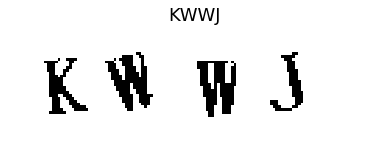

In [4]:
import random
idx = random.randint(0, 4000)
y = ''
for index in range(len(y_train[idx])):
    y += chr(y_train[idx][index]+65)
plt.imshow(X_train[idx], cmap='gray')
plt.title(y, fontsize=18)
plt.axis('off');

# 建構網路

In [5]:
LEARNING_RATE = 0.001
EPOCHS = 10    #80
BATCH_SIZE = 20
DROPOUT = 0.7
LAMBDA = 0.03

In [6]:
def conv2d(input_, W, b, name):
    with tf.variable_scope(name, reuse=tf.AUTO_REUSE):
        x = tf.nn.conv2d(input_, W, strides=[1, 1, 1, 1], padding='SAME')
        x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

def flatten(layer):
    num_features = layer.shape[1:].num_elements()
    flat = tf.reshape(layer, [-1, num_features])
    return flat

def get_weight_bias(weight_size, layer):
    weight = tf.Variable(tf.random_normal(weight_size), name='w'+layer)
    bias = tf.Variable(tf.random_normal([weight_size[-1]]), name='b'+layer)
    return weight, bias

In [7]:
def captcha_network(inputs, num_classes):
    W1, b1 = get_weight_bias([3, 3, 1, 64], '1')
    W2, b2 = get_weight_bias([3, 3, 64, 128], '2')

    l2_regularization = tf.nn.l2_loss(W1) + tf.nn.l2_loss(W2)
        
    x = conv2d(inputs, W1, b1, name='conv1')
    x = tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME', name='pool1')
        
    x = conv2d(x, W2, b2, name='conv2')
    x = tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME', name='pool2')
        
    x = tf.nn.dropout(x, drop)
        
    x = flatten(x)
        
    x0 = tf.layers.dense(x, units=26, name='x0')
    x1 = tf.layers.dense(x, units=26, name='x1')
    x2 = tf.layers.dense(x, units=26, name='x2')
    x3 = tf.layers.dense(x, units=26, name='x3')
    
    return l2_regularization, x0, x1, x2, x3

In [8]:
X = tf.placeholder(tf.float32, [None, 40, 120], name='input')
y0 = tf.placeholder(tf.float32, [None])
y1 = tf.placeholder(tf.float32, [None])
y2 = tf.placeholder(tf.float32, [None])
y3 = tf.placeholder(tf.float32, [None])
drop = tf.placeholder(tf.float32, name='dropout')
lamb = tf.placeholder(tf.float32, name='lambda')

X_reshape = tf.expand_dims(X, -1)    # 將尺寸1插入張量的維度
regularization, logit0, logit1, logit2, logit3 = captcha_network(X_reshape, 26)

oneHotLabel0 = tf.one_hot(indices=tf.cast(y0, tf.int32), depth=26)
oneHotLabel1 = tf.one_hot(indices=tf.cast(y1, tf.int32), depth=26)
oneHotLabel2 = tf.one_hot(indices=tf.cast(y2, tf.int32), depth=26)
oneHotLabel3 = tf.one_hot(indices=tf.cast(y3, tf.int32), depth=26)


# loss
loss0 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=oneHotLabel0, logits=logit0))
loss1 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=oneHotLabel1, logits=logit1))
loss2 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=oneHotLabel2, logits=logit2))
loss3 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=oneHotLabel3, logits=logit3))

totalLoss = (loss0+loss1+loss2+loss3)/4 + lamb*regularization

train_op = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(totalLoss)


# accuracy
y_pred0 = tf.nn.softmax(logit0, name='pred0')
y_pred1 = tf.nn.softmax(logit1, name='pred1')
y_pred2 = tf.nn.softmax(logit2, name='pred2')
y_pred3 = tf.nn.softmax(logit3, name='pred3')

correct_pre0 = tf.equal(tf.argmax(oneHotLabel0, 1), tf.argmax(y_pred0, 1))
correct_pre1 = tf.equal(tf.argmax(oneHotLabel1, 1), tf.argmax(y_pred1, 1))
correct_pre2 = tf.equal(tf.argmax(oneHotLabel2, 1), tf.argmax(y_pred2, 1))
correct_pre3 = tf.equal(tf.argmax(oneHotLabel3, 1), tf.argmax(y_pred3, 1))
    
accuracy0 = tf.reduce_mean(tf.cast(correct_pre0, tf.float32))
accuracy1 = tf.reduce_mean(tf.cast(correct_pre1, tf.float32))
accuracy2 = tf.reduce_mean(tf.cast(correct_pre2, tf.float32))
accuracy3 = tf.reduce_mean(tf.cast(correct_pre3, tf.float32))

In [9]:
def randomize(x, y):
    permutation = np.random.permutation(y.shape[0])
    shuffled_x = x[permutation, :]
    shuffled_y = y[permutation]
    return shuffled_x, shuffled_y

def get_next_batch(x, y, start, end):
    x_batch = x[start:end]
    y_batch = y[start:end]
    return x_batch, y_batch

def split_batch_label(batchLabel):
    batchLabel0 = [splitLabel[0] for splitLabel in batchLabel]
    batchLabel1 = [splitLabel[1] for splitLabel in batchLabel]
    batchLabel2 = [splitLabel[2] for splitLabel in batchLabel]
    batchLabel3 = [splitLabel[3] for splitLabel in batchLabel]
    return batchLabel0, batchLabel1, batchLabel2, batchLabel3

In [10]:
saver = tf.train.Saver()

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

NUM_ITERATION = int(len(y_train) / BATCH_SIZE)         # 跑完一個 epoch 所需要的 iteration 次數
NUM_ITERATION_TEST = int(len(y_test) / BATCH_SIZE)     # 跑完一個 test set 所需要的 iteration 次數

for epoch in range(EPOCHS):
    print('___________________________________________________________________________')
    print('Epoch: {}'.format(epoch + 1))
    print('---------------------------------------------------------------------------')
    
    X_train, y_train = randomize(X_train, y_train)    # 打亂訓練集，避免每次批次都是相同的圖片分布

    for iteration in range(NUM_ITERATION):
        
        # 批次處理
        start = iteration * BATCH_SIZE
        end = start + BATCH_SIZE
        batch_X, batch_y = get_next_batch(X_train, y_train, start, end)
        batch_y0, batch_y1, batch_y2, batch_y3 = split_batch_label(batch_y)
        
        # 執行權重優化
        sess.run(train_op, 
                 feed_dict={X: batch_X, y0: batch_y0, y1: batch_y1, y2: batch_y2, y3: batch_y3, drop: DROPOUT, lamb: LAMBDA})
        
        # 印出訓練集的 Loss 以及 Accuracy
        if (iteration+1) % 20 == 0:
            
            # 取得該批次的 loss 及 Accuracy
            loss, acc0, acc1, acc2, acc3 = sess.run([totalLoss, accuracy0, accuracy1, accuracy2, accuracy3], 
                                                    feed_dict={X: batch_X, y0: batch_y0, y1: batch_y1, y2: batch_y2, y3: batch_y3, 
                                                               drop: DROPOUT, lamb: 0})
            
            print('Iteration: {:2d}/{}\t loss: {:.3f}\t Accuracy: {:.2f}, {:.2f}, {:.2f}, {:.2f}'
                  .format(iteration+1, NUM_ITERATION, loss, acc0, acc1, acc2, acc3))


    batch_loss, batch_acc0, batch_acc1, batch_acc2, batch_acc3 = [], [], [], [], []    # 批次損失以及批次準確率
    
    # 測試集的 Loss 及 Accuracy
    for iteration in range(NUM_ITERATION_TEST):
        
        # 批次處理
        start = iteration * BATCH_SIZE
        end = start + BATCH_SIZE
        batch_X, batch_y = get_next_batch(X_test, y_test, start, end)
        batch_y0, batch_y1, batch_y2, batch_y3 = split_batch_label(batch_y)
        
        # 取得該批次的 loss 及 Accuracy
        feed_dict_test = {X: batch_X, y0: batch_y0, y1: batch_y1, y2: batch_y2, y3: batch_y3, drop: 1}
        loss, acc0, acc1, acc2, acc3 = sess.run([totalLoss, accuracy0, accuracy1, accuracy2, accuracy3],
                                                feed_dict={X: batch_X, y0: batch_y0, y1: batch_y1, y2: batch_y2, y3: batch_y3, 
                                                           drop: 1, lamb: 0})
        batch_loss.append(loss)
        batch_acc0.append(acc0)
        batch_acc1.append(acc1)
        batch_acc2.append(acc2)
        batch_acc3.append(acc3)
        
    # 計算平均 loss 及 Accuracy
    avg_loss = np.mean(batch_loss)
    avg_acc0 = np.mean(batch_acc0)
    avg_acc1 = np.mean(batch_acc1)
    avg_acc2 = np.mean(batch_acc2)
    avg_acc3 = np.mean(batch_acc3)

    print('---------------------------------------------------------------------------')
    print('test_loss: {:.3f}\t Test Accuracy: {:.2f}, {:.2f}, {:.2f}, {:.2f}'.
          format(avg_loss, avg_acc0, avg_acc1, avg_acc2, avg_acc3))
    print('___________________________________________________________________________\n\n')

# save_path = saver.save(sess, '../save_model/model.ckpt')
# tflite_model = tf.lite.toco_convert(sess.graph_def, [X, drop], [y_pred0, y_pred1, y_pred2, y_pred3])
# open('../tfliteModel/model.tflite', "wb").write(tflite_model)

___________________________________________________________________________
Epoch: 1
---------------------------------------------------------------------------
Iteration: 20/280	 loss: 2355.181	 Accuracy: 0.00, 0.00, 0.05, 0.05
Iteration: 40/280	 loss: 487.987	 Accuracy: 0.05, 0.20, 0.10, 0.10
Iteration: 60/280	 loss: 156.298	 Accuracy: 0.30, 0.05, 0.20, 0.20
Iteration: 80/280	 loss: 70.289	 Accuracy: 0.25, 0.15, 0.30, 0.15
Iteration: 100/280	 loss: 57.324	 Accuracy: 0.40, 0.35, 0.55, 0.25
Iteration: 120/280	 loss: 24.622	 Accuracy: 0.60, 0.60, 0.60, 0.25
Iteration: 140/280	 loss: 26.226	 Accuracy: 0.65, 0.50, 0.55, 0.55
Iteration: 160/280	 loss: 17.728	 Accuracy: 0.60, 0.60, 0.30, 0.70
Iteration: 180/280	 loss: 19.754	 Accuracy: 0.70, 0.70, 0.65, 0.55
Iteration: 200/280	 loss: 8.894	 Accuracy: 0.80, 0.80, 0.80, 0.65
Iteration: 220/280	 loss: 15.720	 Accuracy: 0.60, 0.55, 0.65, 0.70
Iteration: 240/280	 loss: 8.660	 Accuracy: 0.75, 0.75, 0.85, 0.80
Iteration: 260/280	 loss: 6.762	 Accu

KeyboardInterrupt: 

In [ ]:
X_train, y_train = randomize(X_train, y_train)
batch_X, batch_y = get_next_batch(X_train, y_train, 0, 10)
pred0, pred1, pred2, pred3 = sess.run([y_pred0, y_pred1, y_pred2, y_pred3], feed_dict={X: batch_X, drop: 1, lamb: 0})

pred0 = np.argmax(pred0, axis=1)
pred1 = np.argmax(pred1, axis=1)
pred2 = np.argmax(pred2, axis=1)
pred3 = np.argmax(pred3, axis=1)

fig = plt.figure(figsize=(20, 5))
for i in range(10):
    # 顯示圖片
    ax = plt.subplot(2, 5, i+1)
    ax.imshow(batch_X[i], cmap='gray')
    ax.axis('off')
    
    # 處理標籤
    y = ''
    for index in range(len(batch_y[i])):
        y += chr(batch_y[i][index]+65)
    title_real = y
    title_predict = chr(pred0[i]+65) + chr(pred1[i]+65) + chr(pred2[i]+65) + chr(pred3[i]+65)
    title = 'Real=' + title_real + '\n' + 'predict=' + title_predict
    
    # 如果預測錯誤，將顯示不相等
    if title_real != title_predict:
        title += '\n' + 'Not equal'
    ax.set_title(title)

In [ ]:
X_test, y_test = randomize(X_test, y_test)
batch_X, batch_y = get_next_batch(X_test, y_test, 0, 10)
pred0, pred1, pred2, pred3 = sess.run([y_pred0, y_pred1, y_pred2, y_pred3], feed_dict={X: batch_X, drop: 1, lamb: 0})

pred0 = np.argmax(pred0, axis=1)
pred1 = np.argmax(pred1, axis=1)
pred2 = np.argmax(pred2, axis=1)
pred3 = np.argmax(pred3, axis=1)

fig = plt.figure(figsize=(20, 5))
for i in range(10):
    # 顯示圖片
    ax = plt.subplot(2, 5, i+1)
    ax.imshow(batch_X[i], cmap='gray')
    ax.axis('off')
    
    # 處理標籤
    y = ''
    for index in range(len(batch_y[i])):
        y += chr(batch_y[i][index]+65)
    title_real = y
    title_predict = chr(pred0[i]+65) + chr(pred1[i]+65) + chr(pred2[i]+65) + chr(pred3[i]+65)
    title = 'Real=' + title_real + '\n' + 'predict=' + title_predict
    
    # 如果預測錯誤，將顯示不相等
    if title_real != title_predict:
        title += '\n' + 'Not equal'
    ax.set_title(title)